In [1]:
import os
import torch
import time
import argparse
import hcpdatautils as hcp
import reservoirutils as resrvoir
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_directory = 'E:\\HCP_data'
output_directory = 'E:\\Ising_model_results_batch'
num_supplementary_inputs = 36
num_epochs = 1000
print_every_seconds = 10
subject_id = 516742
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')
epoch = 0

In [3]:
code_start_time = time.time()
print('loading fMRI data...')
data_ts = hcp.load_all_time_series_for_subject(directory_path=data_directory, subject_id=subject_id, dtype=float_type, device=device)[0,:,:]
print( 'data ts size:', data_ts.size() )
data_fc = hcp.get_fc(ts=data_ts)
print( 'data fc size:', data_fc.size() )
num_time_points, num_regions = data_ts.size()
print( 'time:', time.time() - code_start_time )    

loading fMRI data...
data ts size: torch.Size([1200, 360])
data fc size: torch.Size([360, 360])
time: 0.9295144081115723


In [4]:
Q_output = torch.full( size=(num_regions,), fill_value=0.0, dtype=float_type, device=device )
Q_supplementary = torch.full( size=(num_supplementary_inputs,), fill_value=0.0, dtype=float_type, device=device )
Q = torch.cat( (Q_output, Q_supplementary), dim=0 )

In [5]:
model = resrvoir.IzhikevichReservoirComputer(num_inputs=num_regions+num_supplementary_inputs, num_outputs=num_regions, Q=Q, dtype=float_type, device=device)

In [6]:
supplementary_ts = resrvoir.make_sinusoid_ts_input(num_dimensions=num_supplementary_inputs, num_time_points=num_time_points, dtype=float_type, device=device)

In [7]:
with torch.no_grad():
    num_prerun_steps = 400000
    prerun_supplementary_ts = resrvoir.make_sinusoid_ts_input(num_dimensions=num_supplementary_inputs, num_time_points=num_prerun_steps, dtype=float_type, device=device)
    _, r_ts, is_spike_ts = model.predict(num_steps=num_prerun_steps, supplementary_input_ts=prerun_supplementary_ts, const_input=None, print_every_seconds=print_every_seconds)
    std_r, mean_r = torch.std_mean(r_ts)
    model.set_saved_state()
    print(f'mean r {mean_r:.3g}, std. dev. r {std_r:.3g}, time {time.time()-code_start_time:.3f}')

step 2479, time 13.351
step 6472, time 23.405
step 10490, time 33.679
step 14574, time 44.020
step 18583, time 54.353
step 22452, time 65.274
step 26478, time 75.506
step 30476, time 85.947
step 34435, time 96.314
step 38438, time 106.796
step 42450, time 117.226
step 46545, time 127.624
step 50641, time 137.961
step 54651, time 148.458
step 58697, time 158.960
step 62719, time 169.626
step 66734, time 179.818
step 70758, time 190.155
step 74715, time 200.351
step 78775, time 210.663
step 82855, time 221.086
step 86820, time 231.272
step 90826, time 241.865
step 94903, time 252.061
step 98843, time 262.279
step 102882, time 272.440
step 106955, time 282.637
step 110971, time 293.164
step 115035, time 303.363
step 119101, time 313.559
step 122977, time 323.930
step 126993, time 334.349
step 131022, time 344.703
step 135040, time 355.313
step 139103, time 365.486
step 143085, time 375.824
step 146966, time 386.250
step 151002, time 396.561
step 154926, time 406.906
step 158902, time 417.

300000
torch.Size([2, 300000])


Text(0, 0.5, 'r (firing rate) range and mean of reservoir neurons')

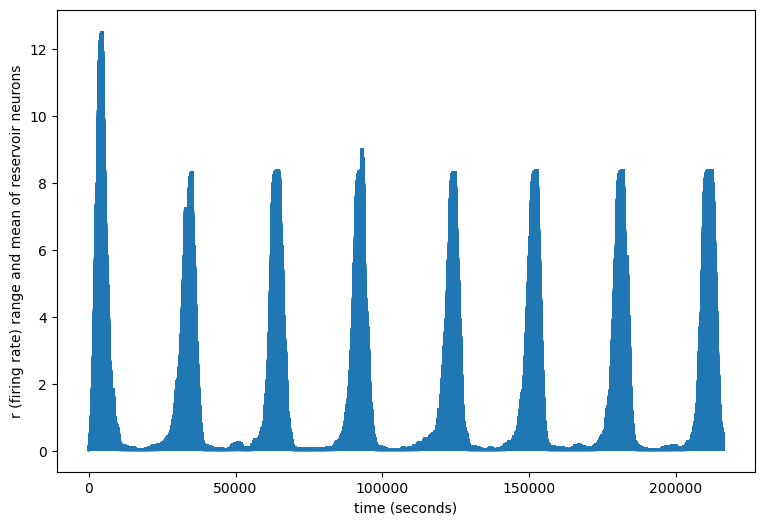

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
prerun_times_seconds = np.arange( start=0, stop=0.72*num_prerun_steps, step=0.72, dtype=float )
print( prerun_times_seconds.size )
# plot range and mean of r
r_middle = r_ts.mean(dim=1)
r_down = r_middle - r_ts.min(dim=1).values
r_up = r_ts.max(dim=1).values - r_middle
r_err = torch.stack( (r_down, r_up), dim=0 )
print( r_err.size() )
axs.errorbar( x=prerun_times_seconds, y=r_middle.detach().cpu().numpy(), yerr=r_err.detach().cpu().numpy() )
axs.set_xlabel('time (seconds)')
axs.set_ylabel('r (network output) range and mean of reservoir neurons')
# axs[0].set_title(f'reservoir computing model trained on subject {subject_id} data')

400000
torch.Size([2, 400000])


Text(0, 0.5, 'postsynaptic current (pA)')

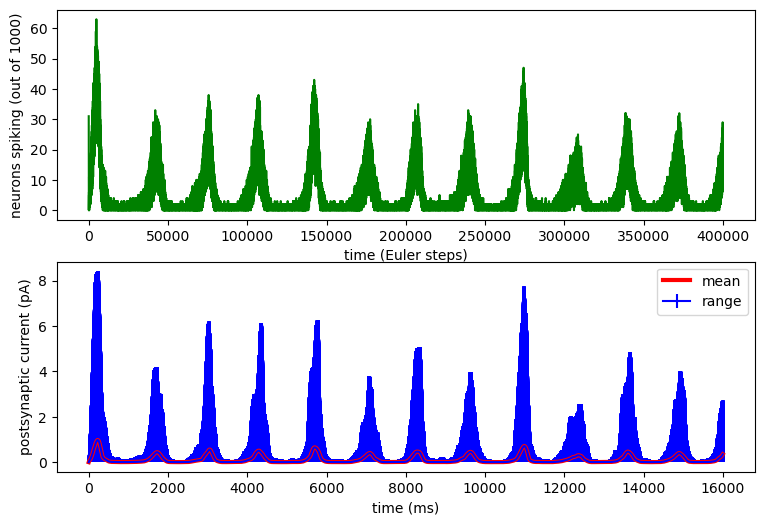

In [15]:
fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(9, 6) )
prerun_times_steps = np.arange(start=0, stop=num_prerun_steps, dtype=float)
prerun_times_seconds = model.dt * prerun_times_steps
print( prerun_times_seconds.size )
num_spikes = torch.sum(is_spike_ts, dim=1)
# plot range and mean of r
r_middle = r_ts.mean(dim=1)
r_down = r_middle - r_ts.min(dim=1).values
r_up = r_ts.max(dim=1).values - r_middle
r_err = torch.stack( (r_down, r_up), dim=0 )
print( r_err.size() )
# axs[0].imshow( is_spike_ts.transpose(dim0=0, dim1=1).detach().cpu().numpy() )
# axs[0].set_xlabel('time (Euler steps)')
# axs[0].set_ylabel(f'spiking')
axs[0].plot( prerun_times_steps, num_spikes.detach().cpu().numpy(), color='green' )
axs[0].set_xlabel('time (Euler steps)')
axs[0].set_ylabel(f'neurons spiking (out of {model.num_neurons})')
axs[1].errorbar( x=prerun_times_seconds, y=r_middle.detach().cpu().numpy(), yerr=r_err.detach().cpu().numpy(), color='blue', label='range' )
axs[1].plot( prerun_times_seconds, r_middle.detach().cpu().numpy(), color='red', label='mean', linewidth=3 )
axs[1].legend()
axs[1].set_xlabel('time (ms)')
axs[1].set_ylabel('postsynaptic current (pA)')
# axs[0].set_title(f'reservoir computing model trained on subject {subject_id} data')

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
prerun_times_seconds = np.arange( start=0, stop=0.72*num_prerun_steps, step=0.72, dtype=float )
print( prerun_times_seconds.size )
# plot range and mean of r
r_middle = r_ts.mean(dim=1)
r_down = r_middle - r_ts.min(dim=1).values
r_up = r_ts.max(dim=1).values - r_middle
r_err = torch.stack( (r_down, r_up), dim=0 )
print( r_err.size() )
axs.errorbar( x=prerun_times_seconds, y=r_middle.detach().cpu().numpy(), yerr=r_err.detach().cpu().numpy() )
axs.set_xlabel('time (seconds)')
axs.set_ylabel('r (network output) range and mean of reservoir neurons')
# axs[0].set_title(f'reservoir computing model trained on subject {subject_id} data')

In [79]:
with torch.no_grad():
    model.train(data_ts=data_ts, supplementary_input_ts=supplementary_ts, const_input=None, num_epochs=1, print_every_seconds=print_every_seconds)
    epoch += 1

In [80]:
with torch.no_grad():
    sim_ts, r_ts = model.predict(num_steps=num_time_points, supplementary_input_ts=supplementary_ts, const_input=None, print_every_seconds=print_every_seconds)
    sim_fc = hcp.get_fc(sim_ts)
    fc_rmse = hcp.get_triu_rmse(sim_fc, data_fc)
    fc_corr = hcp.get_triu_corr(sim_fc, data_fc)
    std_r, mean_r = torch.std_mean(r_ts)
    print(f'epoch {epoch}, RMSE {fc_rmse:.3g}, corr {fc_corr:.3g}, mean r {mean_r:.3g}, std. dev. r {std_r:.3g}, time {time.time()-code_start_time:.3f}')

epoch 25, RMSE 0.864, corr 0.163, mean r 18.8, std. dev. r 1.01, time 727.594


1200
torch.Size([2, 1200])
torch.Size([2, 1200])
torch.Size([2, 1200])


Text(0, 0.5, 'BOLD signal range and mean of data from subject f516742')

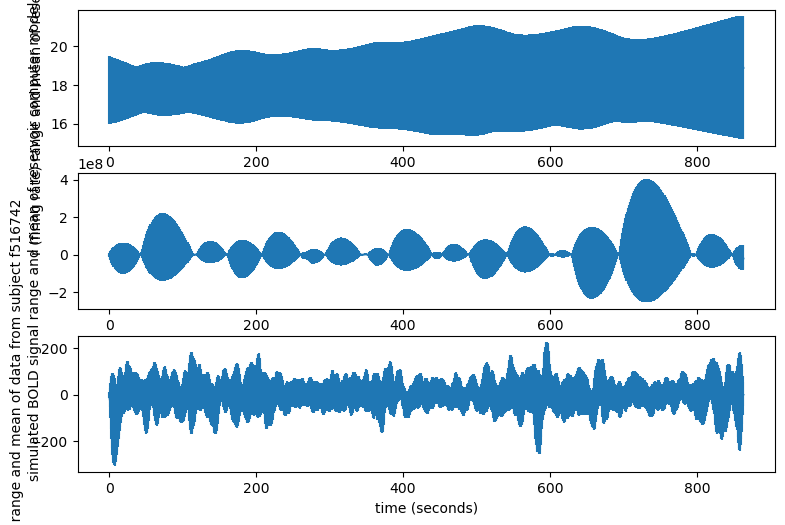

In [81]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(9, 6))
times_seconds = np.arange( start=0, stop=0.72*num_time_points, step=0.72, dtype=float )
print( times_seconds.size )
# plot range and mean of r
r_middle = r_ts.mean(dim=1)
r_down = r_middle - r_ts.min(dim=1).values
r_up = r_ts.max(dim=1).values - r_middle
r_err = torch.stack( (r_down, r_up), dim=0 )
print( r_err.size() )
# plot range and mean of model output
sim_middle = sim_ts.mean(dim=1)
sim_down = sim_middle - sim_ts.min(dim=1).values
sim_up = sim_ts.max(dim=1).values - sim_middle
sim_err = torch.stack( (sim_down, sim_up), dim=0 )
print( sim_err.size() )
# plot range and mean of data
data_middle = data_ts.mean(dim=1)
data_down = data_middle - data_ts.min(dim=1).values
data_up = data_ts.max(dim=1).values - data_middle
data_err = torch.stack( (data_down, data_up), dim=0 )
print( data_err.size() )
axs[0].errorbar( x=times_seconds, y=r_middle.detach().cpu().numpy(), yerr=r_err.detach().cpu().numpy() )
axs[0].set_xlabel('time (seconds)')
axs[0].set_ylabel('r (firing rate) range and mean of reservoir neurons')
axs[1].errorbar( x=times_seconds, y=sim_middle.detach().cpu().numpy(), yerr=sim_err.detach().cpu().numpy() )
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('simulated BOLD signal range and mean of reservoir computer model')
axs[2].errorbar( x=times_seconds, y=data_middle.detach().cpu().numpy(), yerr=data_err.detach().cpu().numpy() )
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel(f'BOLD signal range and mean of data from subject f{subject_id}')
# axs[0].set_title(f'reservoir computing model trained on subject {subject_id} data')

In [16]:
print(1200000/40.5)
print(1200 * 0.72 / 60)

29629.62962962963
14.4
